In [1]:
import os, sys
from pathlib import Path
import yaml
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# Make project imports work (in notebooks __file__ is undefined)
ROOT = Path.cwd()
sys.path.append(str(ROOT))

from src.training.rgba_vae_stage import build_dataloader  # noqa: E402

# Load config
cfg_path = ROOT / "configs/flux_vae.yaml"
with cfg_path.open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# Force a small batch for quick visual checks
cfg.setdefault("data", {})
cfg["data"]["batch_size"] = 16
cfg["data"]["shuffle"] = True  # enable shuffle for probing
cfg["data"]["interleave_buckets"] = True  # mix buckets instead of draining one-by-one

# Build dataloader on CPU
train_loader = build_dataloader(cfg, split="train")
print("Dataloader ready. Batches:", len(train_loader) if hasattr(train_loader, "__len__") else "unknown")


Dataloader ready. Batches: 177025


In [2]:
from collections import Counter
from src.data_generation.bucket_dataset import BucketBatchSampler

# Bucket size stats
bucket_counts = {k: len(v) for k, v in train_loader.dataset.bucket_to_indices.items()}
total_entries = sum(bucket_counts.values())
print("Total entries:", total_entries)
for b, c in sorted(bucket_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"bucket {b:>12}: {c} samples ({c/total_entries:.3%})")

# Simulate sampler order without loading images
num_batches_probe = 200
sampler = BucketBatchSampler(
    train_loader.dataset.bucket_to_indices,
    batch_size=cfg["data"]["batch_size"],
    shuffle=True,
    drop_last=bool(cfg["data"].get("drop_last", False)),
    interleave=True,
)
probe = Counter()
for i, batch_idxs in enumerate(sampler):
    bname = train_loader.dataset.entries[batch_idxs[0]]["bucket"]
    probe[bname] += 1
    if i + 1 >= num_batches_probe:
        break
print("--- First", num_batches_probe, "batches bucket frequency (with shuffle=True)")
for b, c in sorted(probe.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"bucket {b:>12}: {c} batches")


Total entries: 2831275
bucket  w1024-h1024: 2058520 samples (72.706%)
bucket   w960-h1152: 286172 samples (10.108%)
bucket   w832-h1024: 274737 samples (9.704%)
bucket   w768-h1408: 61603 samples (2.176%)
bucket   w832-h1280: 35790 samples (1.264%)
bucket   w1024-h832: 18288 samples (0.646%)
bucket   w1408-h768: 9933 samples (0.351%)
bucket   w1280-h832: 5546 samples (0.196%)
bucket    w768-h512: 4582 samples (0.162%)
bucket   w1216-h896: 4181 samples (0.148%)
bucket    w576-h576: 3924 samples (0.139%)
bucket    w768-h576: 3517 samples (0.124%)
bucket    w768-h768: 3182 samples (0.112%)
bucket   w1024-h704: 2945 samples (0.104%)
bucket   w1024-h640: 2731 samples (0.096%)
bucket   w896-h1216: 2620 samples (0.093%)
bucket   w1024-h768: 2445 samples (0.086%)
bucket   w704-h1024: 2064 samples (0.073%)
bucket    w576-h896: 2033 samples (0.072%)
bucket    w576-h768: 2022 samples (0.071%)
bucket    w640-h640: 2022 samples (0.071%)
bucket    w960-h768: 1466 samples (0.052%)
bucket   w768-h1024

--- First 200 batches bucket frequency (with shuffle=True)
bucket  w1024-h1024: 143 batches
bucket   w960-h1152: 24 batches
bucket   w832-h1024: 19 batches
bucket   w768-h1408: 4 batches
bucket   w1216-h896: 2 batches
bucket    w640-h640: 2 batches
bucket   w1024-h832: 2 batches
bucket    w896-h960: 1 batches
bucket   w1024-h512: 1 batches
bucket   w832-h1280: 1 batches


In [3]:
import math

def to_checkerboard_grid(rgba: torch.Tensor, nrow: int = 4, tile: int = 16):
    """Compose RGBA onto a checkerboard and return a grid tensor in [0,1]."""
    if rgba.dim() == 3:
        rgba = rgba.unsqueeze(0)
    assert rgba.shape[1] >= 4, "Expected RGBA input"
    rgb = rgba[:, :3]
    alpha = rgba[:, 3:4]

    # If values look like [-1,1], map to [0,1]
    if rgb.min() < -0.01 or rgb.max() > 1.01 or alpha.min() < -0.01 or alpha.max() > 1.01:
        rgb = (rgb + 1.0) * 0.5
        alpha = (alpha + 1.0) * 0.5

    rgb = rgb.clamp(0.0, 1.0)
    alpha = alpha.clamp(0.0, 1.0)

    _, _, h, w = rgb.shape
    y = torch.arange(h).view(-1, 1)
    x = torch.arange(w).view(1, -1)
    pattern = ((y // tile + x // tile) % 2).to(dtype=rgb.dtype)
    pattern = pattern * 0.9 + 0.1
    checker = pattern.unsqueeze(0).repeat(3, 1, 1)  # (3, H, W)
    checker = checker.unsqueeze(0).repeat(rgb.shape[0], 1, 1, 1)

    composed = rgb * alpha + checker * (1.0 - alpha)
    return make_grid(composed, nrow=nrow, padding=2)


def get_batch(loader, idx: int):
    for i, batch in enumerate(loader):
        if i == idx:
            return batch
    raise IndexError(f"batch {idx} out of range")


Batch shape: torch.Size([16, 4, 1024, 1024])
Min/Max: 0.0 1.0


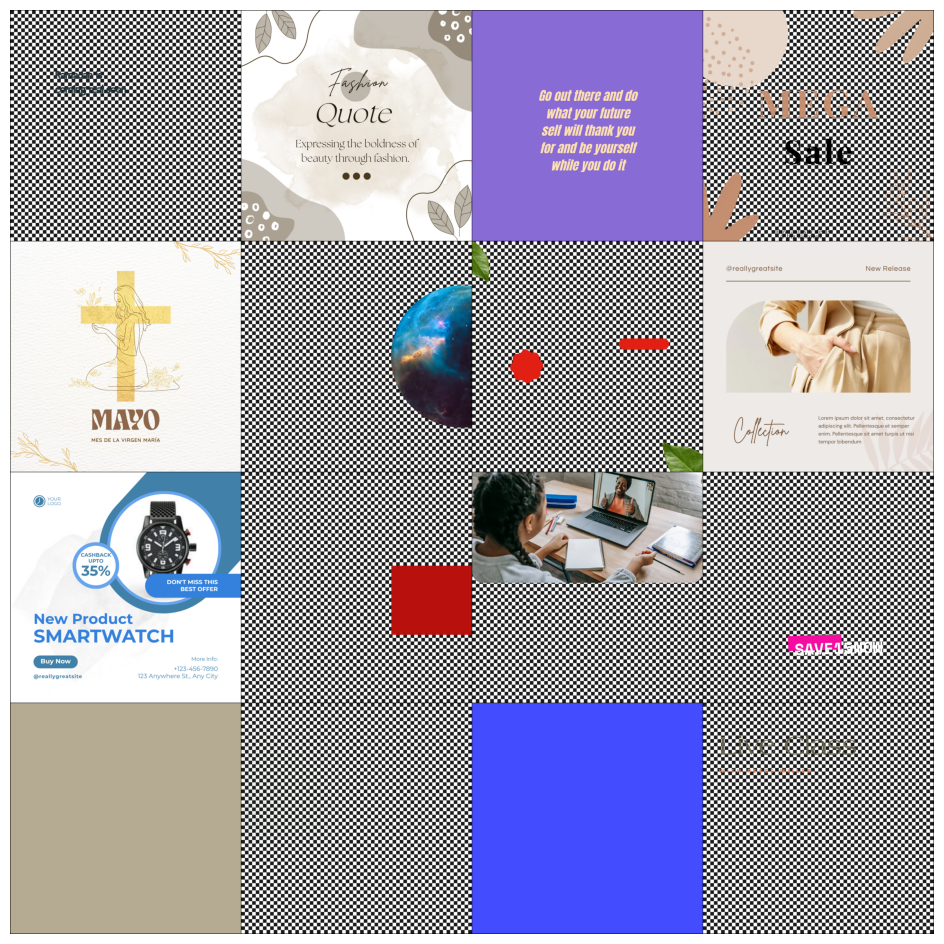

In [4]:
# Change this to step through batches
batch_idx = 1  # e.g., 0, 1, 2...
nrow = 4       # 4 x 4 grid for 16 examples

batch = get_batch(train_loader, batch_idx)
rgba = batch.get("composite")
if rgba is None:
    rgba = batch.get("component")
if rgba is None:
    raise ValueError("Batch missing 'composite' or 'component' tensor")

print("Batch shape:", rgba.shape)
print("Min/Max:", rgba.min().item(), rgba.max().item())

grid = to_checkerboard_grid(rgba, nrow=nrow)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()


In [5]:
from collections import Counter, defaultdict
from pathlib import Path
import yaml
from src.data_generation.bucket_dataset import build_bucket_entries, MixedBucketDataset

cfg = yaml.safe_load(open("configs/flux_vae.yaml"))
data_cfg = cfg["data"]
split = data_cfg.get("bucket_split", "train")
ds_cfgs = data_cfg.get("bucket_datasets", [])

# 엔트리 생성
entries = build_bucket_entries(ds_cfgs, split=split)
print("total entries:", len(entries))

# 데이터셋별 크기 (root 폴더명 기준으로 구분)
by_dataset = Counter(Path(e["root_dir"]).name for e in entries)
print("per dataset counts:", by_dataset)

# 버킷별 크기
by_bucket = Counter(e["bucket"] for e in entries)
print("bucket count (top 10):", by_bucket.most_common(10))

# 버킷별 비율
total = len(entries)
bucket_probs = {b: c/total for b, c in by_bucket.items()}
print("bucket prob (top 10):", sorted(bucket_probs.items(), key=lambda x: x[1], reverse=True)[:10])

total entries: 2831275
per dataset counts: Counter({'lica_250k': 2651409, 'laion1M_aethtetic': 96113, 'prism_layer_pro': 80184, 'prism_layer_real': 3569})
bucket count (top 10): [('w1024-h1024', 2058520), ('w960-h1152', 286172), ('w832-h1024', 274737), ('w768-h1408', 61603), ('w832-h1280', 35790), ('w1024-h832', 18288), ('w1408-h768', 9933), ('w1280-h832', 5546), ('w768-h512', 4582), ('w1216-h896', 4181)]
bucket prob (top 10): [('w1024-h1024', 0.7270646616806916), ('w960-h1152', 0.10107531059328395), ('w832-h1024', 0.09703649415899197), ('w768-h1408', 0.02175804187159495), ('w832-h1280', 0.012640947982799269), ('w1024-h832', 0.006459280712753088), ('w1408-h768', 0.0035083133923762264), ('w1280-h832', 0.0019588348005757125), ('w768-h512', 0.0016183521558308536), ('w1216-h896', 0.0014767198523633345)]
